In [73]:
# install libraries if not already installed, uncomment the following lines

import sys
# !{sys.executable} -m pip install opencv-python opencv-contrib-python matplotlib numpy torch torchvision pandas

In [74]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch


In [75]:
import os
import tarfile

def unpack_tar_gz(file_path, target_folder):
    # Check if the target folder already contains the unpacked files
    if not os.path.exists(target_folder) or not os.listdir(target_folder):
        print(f"Unpacking {file_path} to {target_folder}...")
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(path=target_folder)
        print("Unpacking completed.")
    else:
        print(f"Target folder '{target_folder}' is not empty. Assuming the file is already unpacked.")

# Define the file path and target folder
file_path = 'fer2013.tar.gz'
target_folder = 'data'

# Create the target folder if it does not exist
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Unpack the tar.gz file
unpack_tar_gz(file_path, target_folder)

Target folder 'data' is not empty. Assuming the file is already unpacked.


In [76]:
# dataset is available at https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge
df = pd.read_csv('data/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [77]:
df['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [78]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

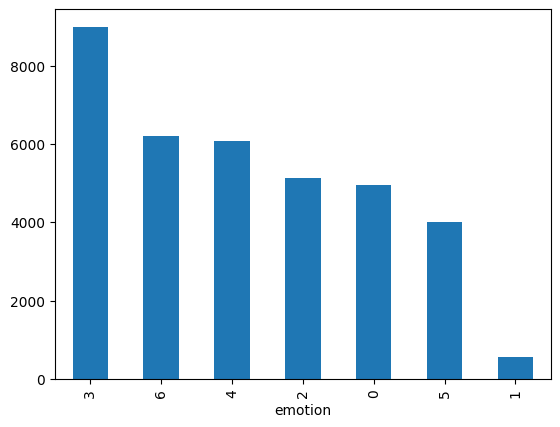

In [79]:
# plot the distribution of the emotions
df['emotion'].value_counts().plot(kind='bar')
plt.show()

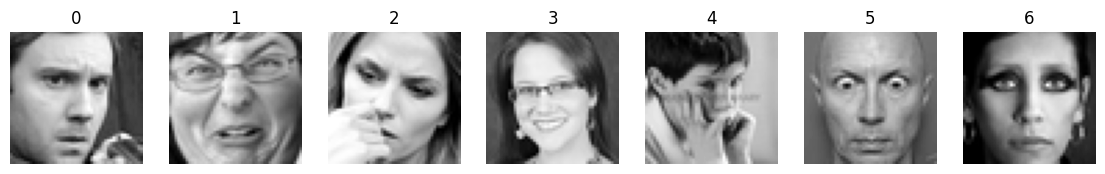

In [80]:
def pixels_to_image(pixels_str):
    pixels = np.fromstring(pixels_str, dtype=int, sep=' ')
    image = pixels.reshape(48, 48)
    return image

# plot each emotion
fig, axes = plt.subplots(1, 7, figsize=(14, 2))
for i in range(7):
    image = pixels_to_image(df[df['emotion'] == i].iloc[0]['pixels'])
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(i)
    axes[i].axis('off')
    
plt.show()